In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Read the country reference file
df_countries = pd.read_csv("CT_COUNTRIES.csv", sep=";", header=None, names=["code", "lang", "name"])

country_dict = df_countries.set_index("code")["name"].to_dict()

In [3]:
import io

FILE_PATH     = "EXPORT_DATA_envoi_01_01_2022_30_04_2025.csv"
TARGET_BYTES  = 1 * 1024**3          # ≈1 GB
ENCODING      = "utf-8-sig"          # handles UTF-8 + BOM

def load_gb_chunk(path, chunk_index=0, target_bytes=TARGET_BYTES, **read_kwargs):
    """
    Load the N-th ≈1 GB chunk (0-based) from a large CSV.

    Parameters
    ----------
    path : str
        CSV file path.
    chunk_index : int
        0 for the first gigabyte, 1 for the second, and so on.
    target_bytes : int
        Approximate raw size for each chunk (defaults to 1 GB).

    Returns
    -------
    pandas.DataFrame
        The requested slice as a DataFrame.
    """
    with open(path, "rb") as f:
        header = f.readline()            # capture header once

        # -------- skip over the earlier chunks --------
        for _ in range(chunk_index):
            skipped = 0
            while skipped < target_bytes:
                line = f.readline()
                if not line:             # hit EOF too soon
                    raise ValueError("chunk_index beyond end of file")
                skipped += len(line)

        # -------- collect the requested chunk --------
        buffers      = [header]
        bytes_so_far = len(header)

        while bytes_so_far < target_bytes:
            line = f.readline()
            if not line:                 # EOF
                break
            bytes_so_far += len(line)
            buffers.append(line)

    pseudo_file = io.BytesIO(b"".join(buffers))

    df = pd.read_csv(
        pseudo_file,
        sep=";",
        encoding=ENCODING,
        on_bad_lines="skip",
        dtype=str,
        low_memory=False,
        **read_kwargs,
    )

    # strip any stray BOM from the first column name
    df.columns = df.columns.str.lstrip("\ufeff")
    return df

# -------- examples --------
df = load_gb_chunk(FILE_PATH, chunk_index=2)  # second GB

print("third:", df.shape)


third: (7930112, 7)


In [4]:
first_row_df = df.head(1)   # first_row_df.shape == (1, df.shape[1])
first_row_df

,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal
0,AEDXBADZALGBAUR40052006000151,RR016755503AE,Expédier envoi à adresse nationale (Ent),2024-09-15 09:20:05.700,ALGER COLIS POSTAUX,35,CONSTANTINE COLIS POSTAUX


In [5]:
last_row_df  = df.tail(1)   # last_row_df.shape  == (1, df.shape[1])
last_row_df

,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal
7930111,DEFRAADZALGBBCN40020005000198,CY582649218DE,Recevoir envoi au bureau d'échange (Ent),2024-01-21 08:44:17.093,ALGER COLIS POSTAUX,30,NaN


In [6]:
distinct_values_count = df.nunique()

distinct_values_count = distinct_values_count.sort_values(ascending=True)

print(distinct_values_count)

EVENT_TYPE_NM                     21
EVENT_TYPE_CD                     21
next_établissement_postal       3585
établissement_postal            3661
RECPTCL_FID                    37996
MAILITM_FID                  1293720
date                         7693717
dtype: int64


In [11]:
print("the number of not missing bags is", 10103605 - 6909038)

the number of not missing bags is 3194567


In [7]:
missing_values = df.isnull().sum()
missing_columns = missing_values[missing_values > 0]
print(missing_columns)

next_établissement_postal    5248262
dtype: int64


In [8]:

# Assuming 'df' is your DataFrame!

# Identify the rows with missing values
missing_rows = df[df.isnull().any(axis=1)]

# Print the total number of rows that have missing values
print("Total rows with missing values:", missing_rows.shape[0])




Total rows with missing values: 5248262


In [9]:
# Analyze the missing patterns across rows:
# Create a binary pattern for each row where 1 indicates a missing value and 0 indicates non-missing.
missing_pattern = missing_rows.isnull().astype(int)
# Convert each pattern to a tuple to use as a key for groupby
missing_pattern_tuples = missing_pattern.apply(tuple, axis=1)
# Group by the missing pattern and count the number of rows for each pattern
pattern_summary = missing_rows.groupby(missing_pattern_tuples).size().sort_values(ascending=False)

print("\nSummary of missing patterns (tuple of 0's and 1's corresponding to missing values in each column):")
print(pattern_summary)




Summary of missing patterns (tuple of 0's and 1's corresponding to missing values in each column):
(0, 0, 0, 0, 0, 0, 1)    5248262
dtype: int64


In [10]:
unique_vals = df['next_établissement_postal'].dropna().unique()
for v in unique_vals:
    print(repr(v))

'CONSTANTINE COLIS POSTAUX'
'ALGER GARE'
'CDD-ALGER-MALIKA-GAID'
'ANNABA-PORT'
'ANNABA EL MARSA'
'ALGER COLIS POSTAUX'
'CTR CHLEF'
'OUED RHIOU'
'CDD BOUMERDES FRANTZ FANON'
'CHERAGA'
'CTR MEDEA'
'KSAR EL BOUKHARI'
'CDD BENAKNOUN'
'CDD TIPAZA'
'CDD BOUIRA'
'ZEBARA'
'CDD OUARGLA'
'BOUAMEUR'
'BAB EZZOUAR 5 JUILLET'
'REGHAIA'
'MAZAGRAN-HAI-DJEDID'
'LARHAT '
'NADOR'
'DOUERA'
'HADJOUT'
'MEURAD '
'ORAN COLIS POSTAUX'
'EL BAYADH RP'
'CHAIBA'
'ISSER'
'KAID YOUCEF '
'CDD SETIF'
'CDD MSILA'
'M SILA-MOHAMED-BOUDIAF'
'CTR GHARDAIA'
'METLILI CHAAMBA'
'CDD BLIDA'
'BOUFARIK-PLACE DES MARTYRS'
'LAKHDARIA'
'DELY BRAHIM'
'DRAA EL BORDJ'
'SIDI MOUSSA'
'BLIDA BEN BOULAID'
'CDD TINDOUF'
'TINDOUF RP'
'OULED YAICH'
'CDD SOUK AHRAS'
'SOUMAA'
'BOUGAA'
'DRARIA'
'BORDJ MENAEIL'
'EL MOURADIA'
'HYDRA'
'SAOULA'
'OUARGLA-EL-WAHAT'
'CDD DJELFA'
'DJELFA-DAYA'
'EL-MEGHAIER'
'HAMMA BOUZIANE'
'CDD BOUROUBA'
'BOUROUBA'
'CDD TIZI-OUZOU'
'AIN-MERANE'
'SAID HAMDINE'
'CTR BECHAR'
'BOUIRA TOUZI DJEDID'
'EL HAMDANIA'
'CDD LAGHOU

EVENT_TYPE_NM
Recevoir envoi au bureau de livraison (Ent)                    1976069
Expédier envoi à adresse nationale (Ent)                       1329401
Expédier envoi à adresse nationale (Srt)                       1319729
Vaine tentative de livraison d'envoi (Ent)                      967137
Recevoir envoi au bureau d'échange (Ent)                        925508
Livraison d'envoi (Ent)                                         812748
Transmettre envoi à l'agent de livraison (Ent)                  525660
Insérer envoi dans sac (Srt)                                     35536
Recevoir envoi au bureau d'échange (Srt)                         23495
Expédier envoi à la douane (Ent)                                  5146
Enregistrer détails d'envoi au bureau d'échange (Srt)             5079
Renvoyer envoi de la douane (Ent)                                 2850
Recevoir envoi au lieu (Ent)                                       906
Mettre à jour envoi (Ent)                                      

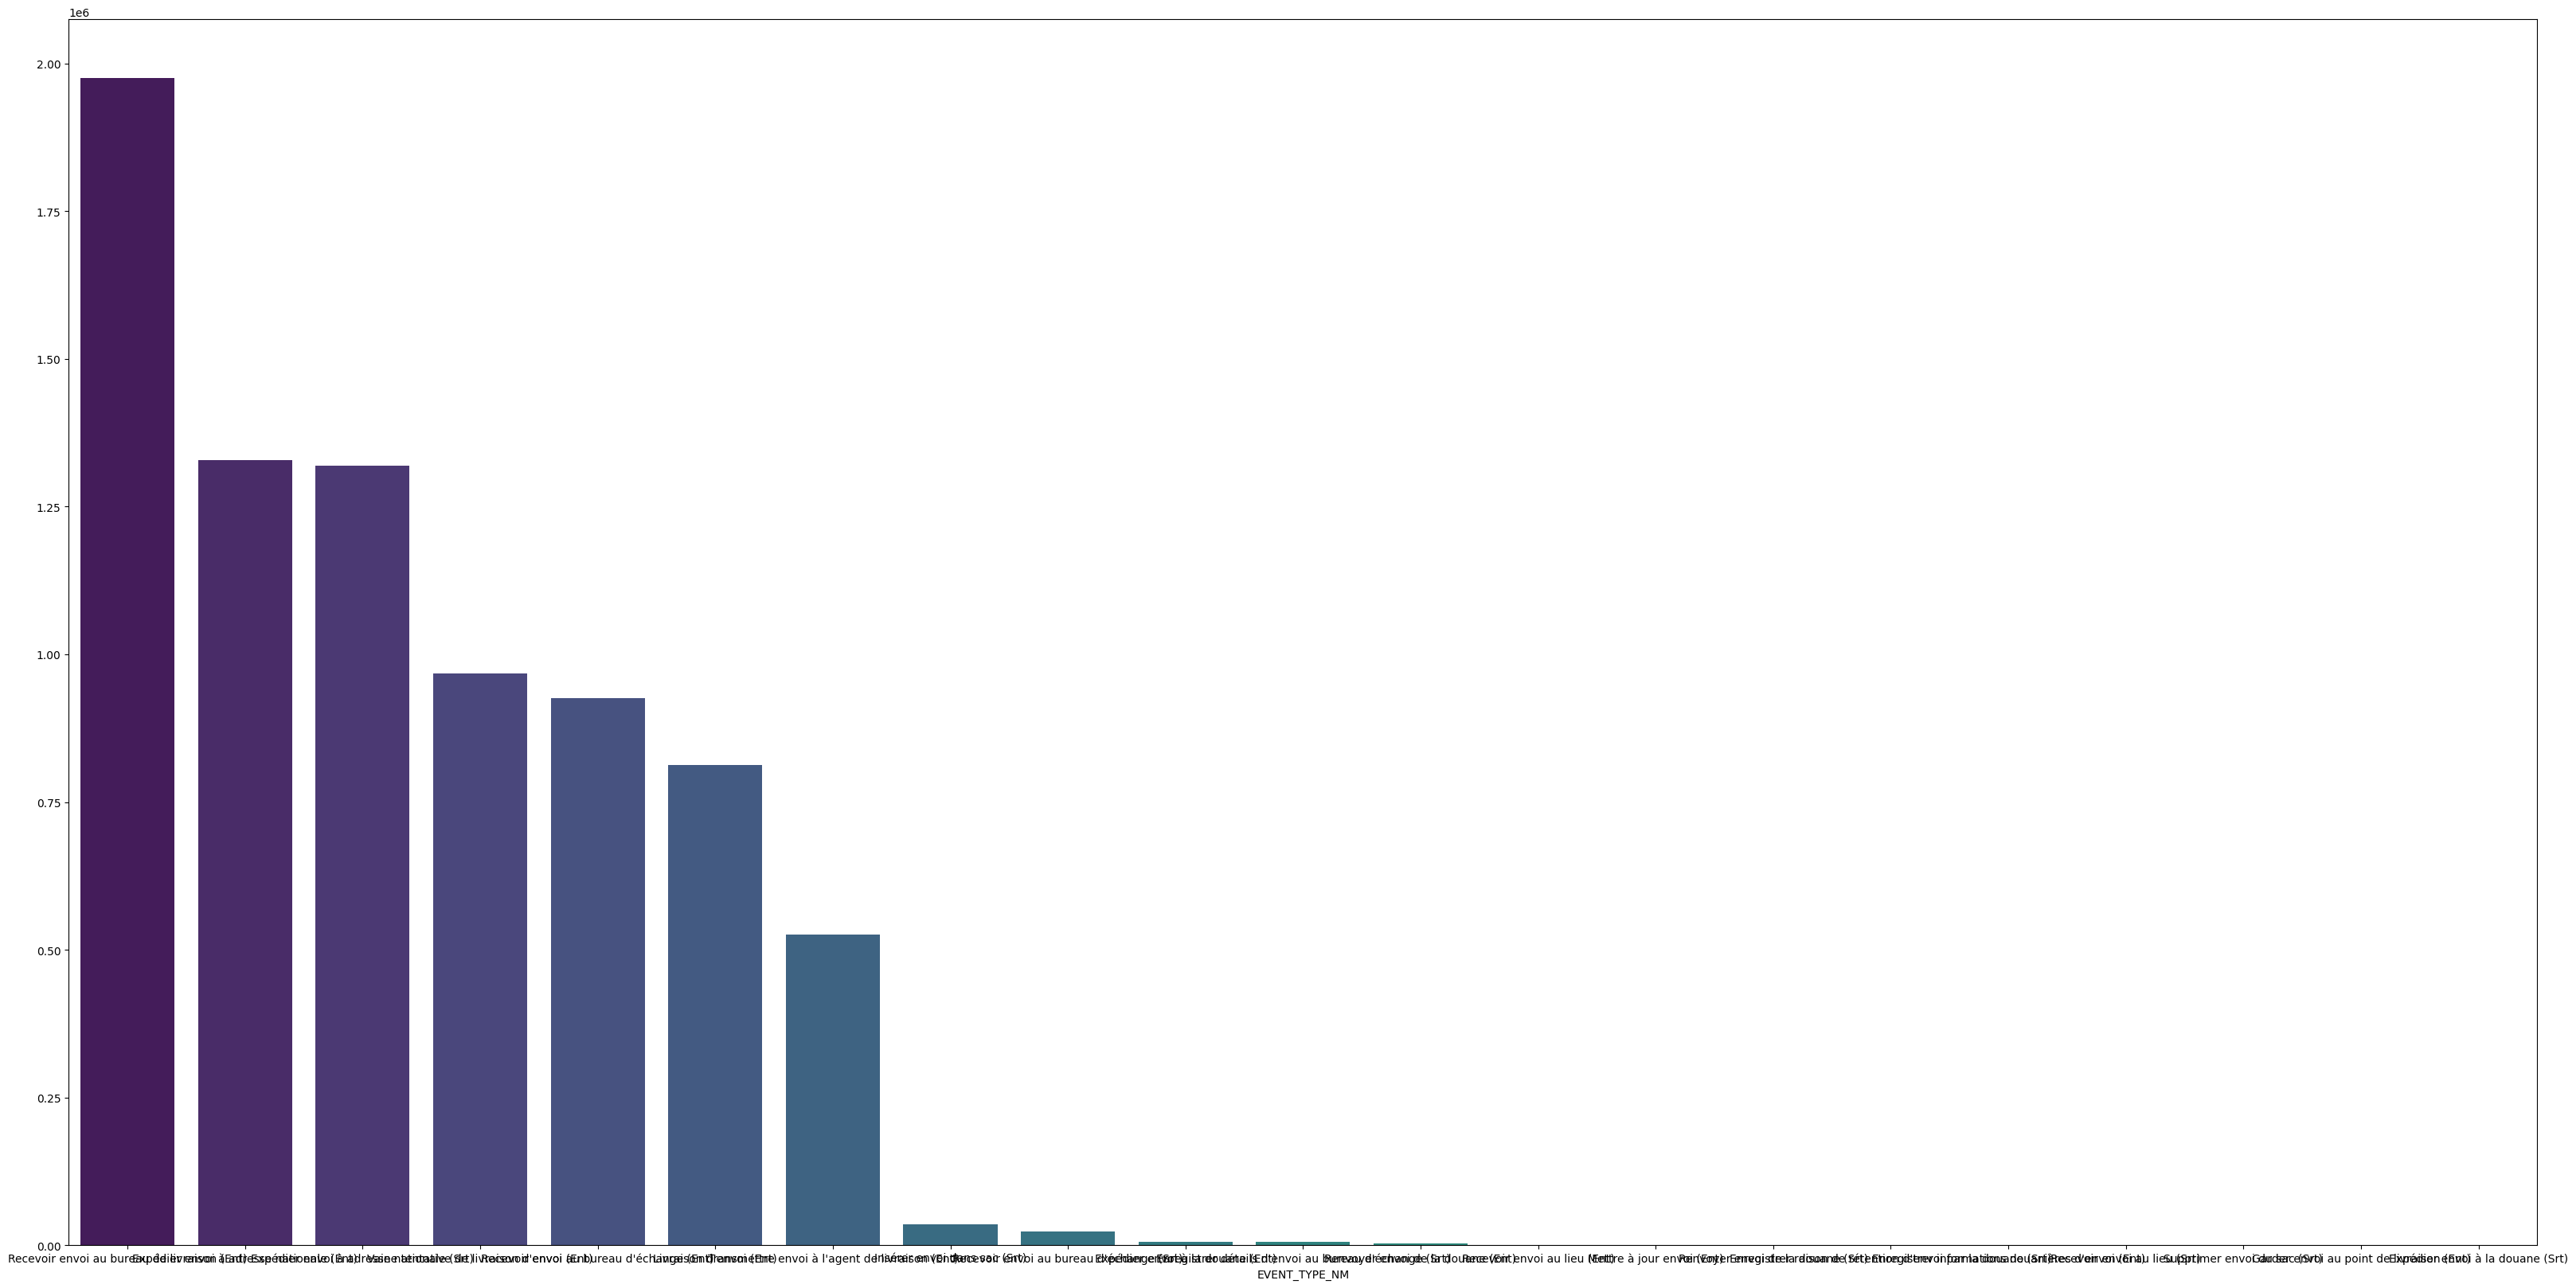

In [11]:

# Count the occurrences of each protocol
event_type = df['EVENT_TYPE_NM'].value_counts()

print(event_type)

# Visualize the counts of each protocol
plt.figure(figsize=(40, 20))
sns.barplot(x=event_type.index, y=event_type.values, palette='viridis')
plt.show()

In [12]:

# Count the occurrences of each protocol
proto_counts = df['établissement_postal'].value_counts()

print(proto_counts)


établissement_postal
ALGER COLIS POSTAUX        1103391
ALGER GARE                 1054280
CONSTANTINE GARE            192712
ANNABA EL MARSA             190349
CDD SETIF                   185939
                            ...   
VIEUX KSAR                       1
GHARDAIA-COLONNEL-LOTFI          1
AGENCE EMS HYDRA                 1
TAMTERT                          1
OUADHIA                          1
Name: count, Length: 3661, dtype: int64


In [13]:
# Count the occurrences of each protocol
proto_counts = df['next_établissement_postal'].value_counts()

print(proto_counts)



next_établissement_postal
ALGER GARE                                 337555
ORAN COLIS POSTAUX                         147555
CONSTANTINE COLIS POSTAUX                  137208
ANNABA EL MARSA                             93294
CDD SETIF                                   90659
                                            ...  
MEDEA RESIDENCE UNIVERSITAIRE 2000 LITS         1
AIN-FERRADJA                                    1
MEDEA YAHIA FARES                               1
BOUSMAIL AMARIA                                 1
CHELGHOUM-LAID-BOUKANA EL MOUSTAKBAL            1
Name: count, Length: 3585, dtype: int64


In [14]:
# Rows whose RECPTCL_FID is not NaN
rec_present = df[df["RECPTCL_FID"].notna()]

# Show the first five
rec_present.head()


,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal
0,AEDXBADZALGBAUR40052006000151,RR016755503AE,Expédier envoi à adresse nationale (Ent),2024-09-15 09:20:05.700,ALGER COLIS POSTAUX,35,CONSTANTINE COLIS POSTAUX
1,AEDXBADZALGBAUR40052006000151,RR016755503AE,Livraison d'envoi (Ent),2024-09-22 12:24:40.713,CDD CONSTANTINE,37,NaN
2,AEDXBADZALGBAUR40052006000151,RR016755503AE,Recevoir envoi au bureau de livraison (Ent),2024-09-18 09:36:30.193,CONSTANTINE GARE,32,NaN
3,AEDXBADZALGBAUR40052006000151,RR016755503AE,Transmettre envoi à l'agent de livraison (Ent),2024-09-19 07:10:30.417,CDD CONSTANTINE,39,NaN
4,AEDXBADZALGBAUR40052006000151,RR016755503AE,Vaine tentative de livraison d'envoi (Ent),2024-09-19 07:04:53.517,CDD CONSTANTINE,36,NaN


In [4]:
# 1️⃣  Make sure the column is treated as text (protects against NaNs)
fid = df["MAILITM_FID"].astype("string")

# 2️⃣  Boolean mask: True if both trailing characters are letters (A-Z / a-z)
two_letter_suffix = fid.str[-2:].str.isalpha()

# --- Quick sanity check
print(two_letter_suffix.value_counts(dropna=False))
# True  : rows where the code ends in letters (e.g. "ES")
# False : rows where it ends in digits or something else
# <NA>  : rows where MAILITM_FID itself is missing


MAILITM_FID
True    7930112
Name: count, dtype: Int64


In [5]:
bad_suffix = df[~two_letter_suffix & fid.notna()]

print(f"Bad rows: {len(bad_suffix):,}")
bad_suffix.head()   # peek at the first few offenders



Bad rows: 0


,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal


In [6]:
# Build the “good suffix” mask once
suffix_ok = (
    df["MAILITM_FID"]
      .astype("string")
      .str[-2:]
      .str.isalpha()
      .fillna(False)          # treat missing IDs as bad
)

df = df[suffix_ok]

# Quick confirmation
print(f"Rows left: {len(df):,}")
df.head()


Rows left: 7,930,112


,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal
0,AEDXBADZALGBAUR40052006000151,RR016755503AE,Expédier envoi à adresse nationale (Ent),2024-09-15 09:20:05.700,ALGER COLIS POSTAUX,35,CONSTANTINE COLIS POSTAUX
1,AEDXBADZALGBAUR40052006000151,RR016755503AE,Livraison d'envoi (Ent),2024-09-22 12:24:40.713,CDD CONSTANTINE,37,NaN
2,AEDXBADZALGBAUR40052006000151,RR016755503AE,Recevoir envoi au bureau de livraison (Ent),2024-09-18 09:36:30.193,CONSTANTINE GARE,32,NaN
3,AEDXBADZALGBAUR40052006000151,RR016755503AE,Transmettre envoi à l'agent de livraison (Ent),2024-09-19 07:10:30.417,CDD CONSTANTINE,39,NaN
4,AEDXBADZALGBAUR40052006000151,RR016755503AE,Vaine tentative de livraison d'envoi (Ent),2024-09-19 07:04:53.517,CDD CONSTANTINE,36,NaN


In [7]:
df['id'] = df["MAILITM_FID"].str[-2:]
df.head()

,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal,id
0,AEDXBADZALGBAUR40052006000151,RR016755503AE,Expédier envoi à adresse nationale (Ent),2024-09-15 09:20:05.700,ALGER COLIS POSTAUX,35,CONSTANTINE COLIS POSTAUX,AE
1,AEDXBADZALGBAUR40052006000151,RR016755503AE,Livraison d'envoi (Ent),2024-09-22 12:24:40.713,CDD CONSTANTINE,37,NaN,AE
2,AEDXBADZALGBAUR40052006000151,RR016755503AE,Recevoir envoi au bureau de livraison (Ent),2024-09-18 09:36:30.193,CONSTANTINE GARE,32,NaN,AE
3,AEDXBADZALGBAUR40052006000151,RR016755503AE,Transmettre envoi à l'agent de livraison (Ent),2024-09-19 07:10:30.417,CDD CONSTANTINE,39,NaN,AE
4,AEDXBADZALGBAUR40052006000151,RR016755503AE,Vaine tentative de livraison d'envoi (Ent),2024-09-19 07:04:53.517,CDD CONSTANTINE,36,NaN,AE


In [19]:

# Count the occurrences of each protocol
proto_counts = df['id'].value_counts()

print(proto_counts)

s = proto_counts


id
AE    4267209
CZ    2449370
CN     903174
DE     103183
BE      63387
       ...   
cz          4
MA          4
UZ          4
AG          3
FI          3
Name: count, Length: 72, dtype: int64


In [20]:
# Map the Series index using the country_dict
s.index = s.index.map(lambda code: country_dict.get(code, code))  # Keep unmapped codes as-is
print(s)

id
ÉMIRATS ARABES UNIS    4267209
TCHÈQUE, RÉPUBLIQUE    2449370
CHINE                   903174
ALLEMAGNE               103183
BELGIQUE                 63387
                        ...   
cz                           4
MAROC                        4
OUZBÉKISTAN                  4
ANTIGUA-ET-BARBUDA           3
FINLANDE                     3
Name: count, Length: 72, dtype: int64


In [21]:
print("Min date:", df["date"].min())
print("Max date:", df["date"].max())

Min date: 2020-01-05 11:36:57.740
Max date: 2025-05-21 15:50:19.793


In [8]:
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d %H:%M:%S.%f")
# Sort by ID and date
df = df.sort_values(by=["MAILITM_FID", "date"])

# Calculate time to next step
df["duration_to_next_step"] = df.groupby("MAILITM_FID")["date"].shift(-1) - df["date"]

# Calculate total duration per ID
first_date = df.groupby("MAILITM_FID")["date"].transform("first")
last_date = df.groupby("MAILITM_FID")["date"].transform("last")
df["total_duration"] = last_date - first_date

# Preview the updated dataset
df[["MAILITM_FID", "date", "EVENT_TYPE_NM", "duration_to_next_step", "total_duration"]].head(10)


,MAILITM_FID,date,EVENT_TYPE_NM,duration_to_next_step,total_duration
6350849,CA001118068BF,2023-03-19 09:45:01.470,Recevoir envoi au bureau d'échange (Ent),0 days 00:57:20.573000,7 days 00:23:02.097000
2689659,CA001118068BF,2023-03-19 10:42:22.043,Expédier envoi à adresse nationale (Ent),0 days 00:06:35.174000,7 days 00:23:02.097000
2689660,CA001118068BF,2023-03-19 10:48:57.217,Expédier envoi à adresse nationale (Ent),2 days 00:40:14.880000,7 days 00:23:02.097000
2689663,CA001118068BF,2023-03-21 11:29:12.097,Recevoir envoi au bureau de livraison (Ent),0 days 00:00:49.283000,7 days 00:23:02.097000
2689658,CA001118068BF,2023-03-21 11:30:01.380,Enregistrer détails d'envoi au bureau d'échang...,0 days 00:04:05.510000,7 days 00:23:02.097000
6350846,CA001118068BF,2023-03-21 11:34:06.890,Expédier envoi à adresse nationale (Srt),1 days 21:34:00.837000,7 days 00:23:02.097000
6350847,CA001118068BF,2023-03-23 09:08:07.727,Recevoir envoi au bureau de livraison (Ent),0 days 00:00:34.300000,7 days 00:23:02.097000
2689661,CA001118068BF,2023-03-23 09:08:42.027,Expédier envoi à adresse nationale (Srt),2 days 01:36:05.513000,7 days 00:23:02.097000
6350848,CA001118068BF,2023-03-25 10:44:47.540,Recevoir envoi au bureau de livraison (Ent),0 days 00:00:30.660000,7 days 00:23:02.097000
6350850,CA001118068BF,2023-03-25 10:45:18.200,Vaine tentative de livraison d'envoi (Ent),0 days 00:00:17.327000,7 days 00:23:02.097000


In [10]:
df.to_csv("df_with_durations_03.csv", index=False, encoding='utf-8-sig')

In [22]:
print("no zervo duration", 10103602 - 1712240)

no zervo duration 8391362


In [11]:
# Filter rows where total_duration is NOT zero
zero_duration_df = df[df["total_duration"] == pd.Timedelta(0)]

# Display the first few rows as a check
zero_duration_df.shape


(29496, 10)

In [12]:

# Count the occurrences of each protocol
countries = zero_duration_df['id'].value_counts()

print(countries)


id
CZ    18909
AE     9366
DE     1089
CN       79
BE       15
SI       12
LU        8
CA        5
SK        5
CH        2
BH        2
ES        1
XZ        1
AR        1
PE        1
Name: count, dtype: int64


In [13]:
# Map the Series index using the country_dict
countries.index = countries.index.map(lambda code: country_dict.get(code, code))  
print(countries)

id
TCHÈQUE, RÉPUBLIQUE    18909
ÉMIRATS ARABES UNIS     9366
ALLEMAGNE               1089
CHINE                     79
BELGIQUE                  15
SLOVÉNIE                  12
LUXEMBOURG                 8
CANADA                     5
SLOVAQUIE                  5
SUISSE                     2
BAHREÏN                    2
ESPAGNE                    1
XZ                         1
ARGENTINE                  1
PÉROU                      1
Name: count, dtype: int64


In [14]:
# Step 1: Count how many times each ID appears
id_counts = zero_duration_df["MAILITM_FID"].value_counts()

# Step 2: Count how many IDs have a specific count
count_of_counts = id_counts.value_counts().sort_index()

print(count_of_counts)


count
1    29496
Name: count, dtype: int64


In [15]:
ids_with_0 = id_counts[id_counts == 1].index
df_with_0 = df[df["MAILITM_FID"].isin(ids_with_0)]
df_with_0.head(20)

,RECPTCL_FID,MAILITM_FID,EVENT_TYPE_NM,date,établissement_postal,EVENT_TYPE_CD,next_établissement_postal,id,duration_to_next_step,total_duration
7799477,DEFRAADZALGBACN30413003000067,CA095923572DE,Expédier envoi à adresse nationale (Ent),2023-06-06 10:50:47.840,ALGER COLIS POSTAUX,35,VISITE DOUANE CPX ALGER,DE,NaT,0 days
7817269,DEFRAADZALGBACN40200003100045,CA158615266DE,Livraison d'envoi (Ent),2024-08-06 09:40:14.417,MOHAMADIA,37,NaN,DE,NaT,0 days
7812069,DEFRAADZALGBACN30890001100084,CA211050105DE,Expédier envoi à adresse nationale (Ent),2023-12-17 12:34:32.327,ALGER COLIS POSTAUX,35,VISITE DOUANE CPX ALGER,DE,NaT,0 days
7817371,DEFRAADZALGBACN40205001000059,CA217017031DE,Recevoir envoi au bureau d'échange (Ent),2024-08-11 09:49:41.423,ALGER COLIS POSTAUX,30,NaN,DE,NaT,0 days
7771114,DEFRAADZALGBACN20128001100042,CA303696331DE,Expédier envoi à la douane (Ent),2022-05-15 07:56:59.377,ALGER COLIS POSTAUX,31,VISITE DOUANE CPX ALGER,DE,NaT,0 days
7813089,DEFRAADZALGBACN40015004000081,CA388999110DE,Expédier envoi à adresse nationale (Ent),2024-01-22 10:45:56.007,ALGER COLIS POSTAUX,35,VISITE DOUANE CPX ALGER,DE,NaT,0 days
7904906,DEFRAADZALGBBCN30608001100172,CA422859242DE,Expédier envoi à la douane (Ent),2023-07-24 08:49:57.923,ALGER COLIS POSTAUX,31,NaN,DE,NaT,0 days
7905214,DEFRAADZALGBBCN30616001100105,CA422859287DE,Expédier envoi à la douane (Ent),2023-07-24 09:19:13.707,ALGER COLIS POSTAUX,31,NaN,DE,NaT,0 days
7817383,DEFRAADZALGBACN40208001100051,CA467816975DE,Expédier envoi à adresse nationale (Ent),2024-08-12 09:41:18.267,ALGER COLIS POSTAUX,35,ORAN COLIS POSTAUX,DE,NaT,0 days
7813444,DEFRAADZALGBACN40037001000047,CA557075999DE,Recevoir envoi au bureau de livraison (Ent),2024-02-29 09:26:50.773,ORAN COLIS POSTAUX,32,NaN,DE,NaT,0 days


In [16]:

# Count the occurrences of each protocol
event_type = df_with_0['EVENT_TYPE_NM'].value_counts()

print(event_type)



EVENT_TYPE_NM
Expédier envoi à adresse nationale (Ent)          6394
Recevoir envoi au bureau de livraison (Ent)       6047
Recevoir envoi au bureau d'échange (Ent)          5198
Expédier envoi à adresse nationale (Srt)          3803
Livraison d'envoi (Ent)                           3431
Vaine tentative de livraison d'envoi (Ent)        2450
Transmettre envoi à l'agent de livraison (Ent)    1418
Expédier envoi à la douane (Ent)                   304
Insérer envoi dans sac (Srt)                       210
Recevoir envoi au bureau d'échange (Srt)           181
Renvoyer envoi de la douane (Ent)                   53
Recevoir envoi au lieu (Ent)                         4
Mettre à jour envoi (Ent)                            2
Recevoir envoi au lieu (Srt)                         1
Name: count, dtype: int64
